In [1]:
import models
import constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
folder = './data/scenarios/'

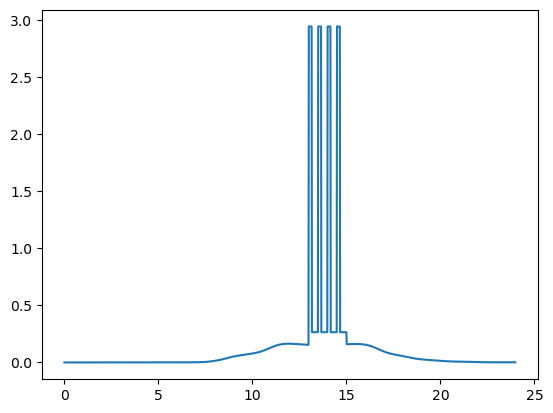

In [3]:
test_scenario_rectangular_peak = pd.read_csv(folder+'00200_rectangular_pulse_210lux.csv', sep=",", decimal=".",header=0,names=['hours', 'irradiance_mel'])
test_scenario_rectangular_bursts = pd.read_csv(folder+'19437_rectangular_bursts_200lux_burst2220lux.csv', sep=",", decimal=".",header=0,names=['hours', 'irradiance_mel'])
test_scenario_rectangular_bursts

plt.plot(test_scenario_rectangular_bursts['hours'], test_scenario_rectangular_bursts['irradiance_mel'])

In [4]:
from datetime import datetime, timedelta
from scipy.interpolate import interp1d

def generate_time_points(start_time="07:30", end_time="17:00", interval_minutes=6):
    """Generate time points between start and end times at given interval."""
    fmt = "%H:%M"
    start = datetime.strptime(start_time, fmt)
    end = datetime.strptime(end_time, fmt)

    time_points = []
    current = start
    while current <= end:
        time_points.append(current.strftime(fmt))
        current += timedelta(minutes=interval_minutes)

    return time_points

def daytime_pattern(time_points, csv_data=None):
    """Generate a pattern of light exposure throughout the day."""
    if csv_data is None:
        # Read the daylight intensity curve from CSV if not provided
        daytime_df = pd.read_csv('./data/daytime_irradiance_curve.csv')
        csv_hours = daytime_df['time'].values
        csv_irradiance = daytime_df['irradiance'].values
    else:
        # Unpack the provided data
        csv_hours, csv_irradiance = csv_data

    # Convert time_points to datetime objects for interpolation
    time_dt = [datetime.strptime(t, '%H:%M') for t in time_points]
    time_decimals = [(t.hour + t.minute/60) for t in time_dt]

    # Create interpolation function
    interpolator = interp1d(csv_hours, csv_irradiance, kind='cubic', bounds_error=False, 
                            fill_value=(csv_irradiance[0], csv_irradiance[-1]))

    # Get relative intensity values from interpolation
    irradiance = interpolator(time_decimals) / constants.CONVERSION_FACTOR

    return irradiance.tolist()

time_points = generate_time_points(start_time="00:00", end_time="23:59", interval_minutes=1)
irradiance = daytime_pattern(time_points) + daytime_pattern(time_points) 
len(irradiance)



2880

In [5]:
import os
import pickle
import time
import pandas as pd
from tqdm.notebook import tqdm

# Dictionary to store results
scenario_results = {}

# Create a timestamp for the filename
timestamp = time.strftime("%Y%m%d-%H%M%S")
output_filename = f"scenario_results_{timestamp}.pkl"

# Get all CSV files in the folder
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]

# filter for specific scenarios
csv_files = [f for f in csv_files if 'rectangular' in f]
csv_files

['21531_rectangular_bursts_220lux_burst4140lux.csv',
 '21538_rectangular_bursts_220lux_burst4210lux.csv',
 '03192_rectangular_pulse_3202lux.csv',
 '19922_rectangular_bursts_200lux_burst7070lux.csv',
 '21076_rectangular_bursts_210lux_burst9100lux.csv',
 '01413_rectangular_pulse_1423lux.csv',
 '08285_rectangular_bursts_80lux_burst4820lux.csv',
 '07376_rectangular_bursts_70lux_burst5240lux.csv',
 '06104_rectangular_bursts_60lux_burst2030lux.csv',
 '02007_rectangular_pulse_2017lux.csv',
 '04111_rectangular_pulse_4121lux.csv',
 '11550_rectangular_bursts_110lux_burst8940lux.csv',
 '11588_rectangular_bursts_110lux_burst9320lux.csv',
 '10260_rectangular_bursts_100lux_burst5550lux.csv',
 '05550_rectangular_bursts_50lux_burst6000lux.csv',
 '03841_rectangular_pulse_3851lux.csv',
 '11059_rectangular_bursts_110lux_burst4030lux.csv',
 '15912_rectangular_bursts_160lux_burst5010lux.csv',
 '24249_rectangular_bursts_250lux_burst2790lux.csv',
 '16320_rectangular_bursts_160lux_burst9090lux.csv',
 '08903_r

In [8]:

# Process each file
for file in tqdm(csv_files[0:10]):
    # Extract scenario name from filename (without extension)
    scenario_name = os.path.splitext(file)[0]
    
    # Load the scenario data
    scenario = pd.read_csv(folder + file, sep=",", decimal=".",
                          header=0, names=['hours', 'irradiance_mel'])
        
    # input_irradiance = irradiance + scenario['irradiance_mel'].tolist()
    input_irradiance = irradiance + daytime_pattern(time_points) 

    interpolator = interp1d(
        np.linspace(0, 3 * 24 * 60 * 60, len(input_irradiance), dtype=int), # seconds in 3 days
        input_irradiance, # 3 days of data at 1 minute intervals
        kind="cubic",
        bounds_error=False,
        fill_value=(input_irradiance[0], input_irradiance[-1]),
    )

    # Run the model
    sol, t = models.model_run(3, 1000, interpolator=interpolator, waketime = 8, bedtime = 20, debug=False)
    
    # Store the solution with the scenario name as key
    scenario_results[scenario_name] = {
        'solution': sol,
        'time': t,
        'irradiance': input_irradiance,
        'scenario_data': scenario,
    }

with open(output_filename, 'wb') as f:
    pickle.dump(scenario_results, f)
    
print(f"Processed {len(scenario_results)} scenarios")

  0%|          | 0/10 [00:00<?, ?it/s]

Processed 10 scenarios


In [ ]:
# Load previously saved results
# import pickle

# output_filename = './scenario_results_20250623-195622.pkl'

# # Load the results
# with open(output_filename, 'rb') as f:
#     scenario_results = pickle.load(f)

In [9]:
# go through the loaded results and calculate KSS, AMT6, and RHO_B
# find scnarios in each category that have the same KSS, AMT6, and RHO_B
# TODO: the alertness should be the same during the 13-15h window on the third day
from tqdm.notebook import tqdm

metrics = {}
for scenario_name, data in tqdm(scenario_results.items()):
    sol = data['solution']
    t = data['time']
    irradiance = data['irradiance']
    scenario_data = data['scenario_data']

    interpolator = interp1d(
        np.linspace(0, 3 * 24 * 60 * 60, 4320, dtype=int),
        irradiance,
        kind="cubic",
        bounds_error=False,
        fill_value=(irradiance[0], irradiance[-1]),
    )
    
    # Calculate KSS, AMT6, and RHO_B
    V_v = sol[:, 0]
    V_m = sol[:, 1]
    H = sol[:, 2]
    X = sol[:, 3]
    Y = sol[:, 4]
    P = sol[:, 5]
    Theta_L = sol[:, 6]
    A = sol[:,7]
    rho_b = sol[:, 8]
    C = models.circadian_drive_v(X,Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    IE = [models.irradiance(time, interpolator) for time in t]
    aMT6s = [models.urinary_excretion_rate(rho_b, t, time) for time in t]
    
    metrics[scenario_name] = {
        'V_v': V_v,
        'V_m': V_m,
        'H': H,
        'X': X,
        'Y': Y,
        'P': P,
        'Theta_L': Theta_L,
        'A': A,
        'KSS': KSS,
        'aMT6s': aMT6s,
        'RHO_B': rho_b,
        'irradiance': irradiance,
        'IE': IE,
        'time': t,
        'scenario_data': scenario_data
    }


  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Theta_L')

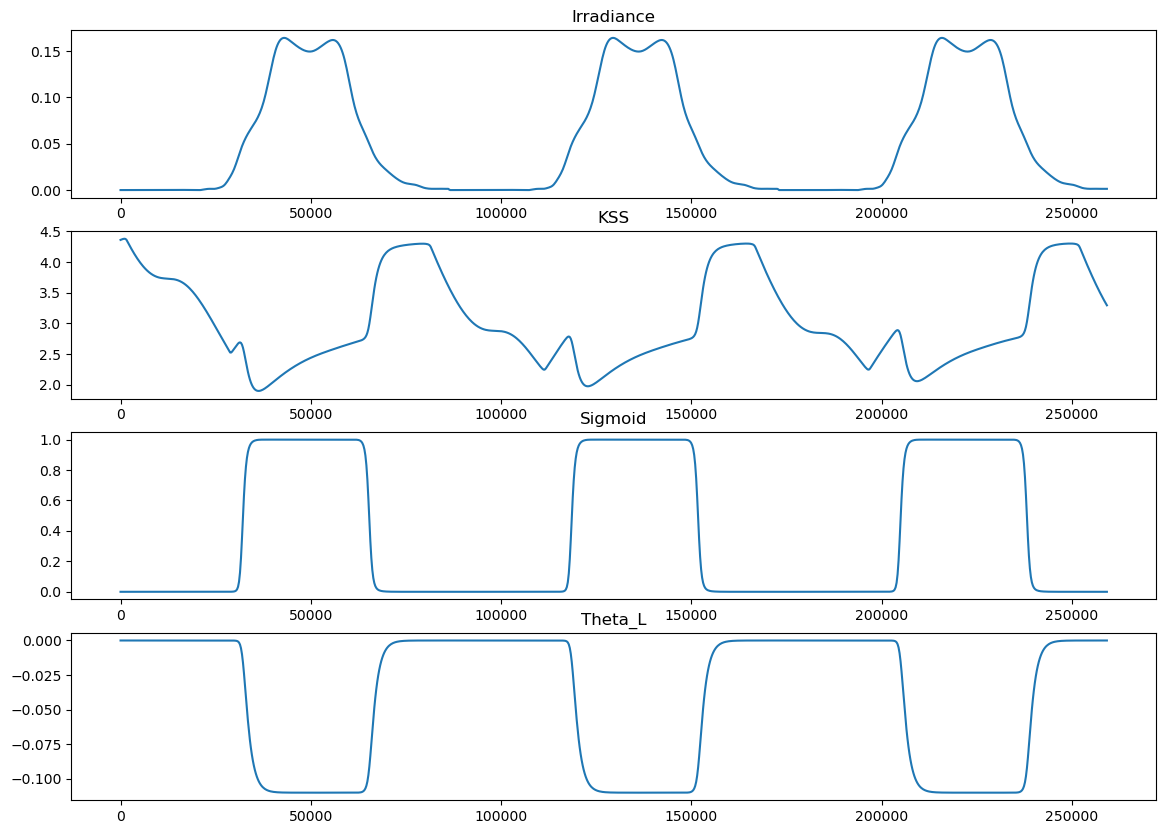

In [10]:
rectangular_pulse_scenarios = {k: v for k, v in metrics.items() if 'rectangular_pulse' in k}  
rectangular_bursts_scenarios = {k: v for k, v in metrics.items() if 'rectangular_bursts' in k}

# temp = rectangular_bursts_scenarios['21531_rectangular_bursts_220lux_burst4140lux']
temp = rectangular_pulse_scenarios['02007_rectangular_pulse_2017lux']

Sigmoid = [models.sigmoid(irr) for irr in temp['IE']]
# Sigmoid = [(models.sigmoid(irr) - models.sigmoid(0)) / (models.sigmoid(1000) - models.sigmoid(0)) for irr in temp['IE']]
# Sigmoid = ( models.sigmoid_v(temp['IE']) - models.sigmoid_v(0) ) / ( models.sigmoid_v(1000) - models.sigmoid_v(0) )

fig, axs = plt.subplots(4, 1, figsize=(14, 10))

# axs[0].plot(temp['time'], temp['irradiance'])
# axs[0].set_title(f"Irradiance")

axs[0].plot(temp['time'], temp['IE'])
axs[0].set_title(f"Irradiance")

axs[1].plot(temp['time'], temp['KSS'])
axs[1].set_title(f"KSS")

axs[2].plot(temp['time'], Sigmoid)
axs[2].set_title(f"Sigmoid")

axs[3].plot(temp['time'], temp['Theta_L'])
axs[3].set_title(f"Theta_L")

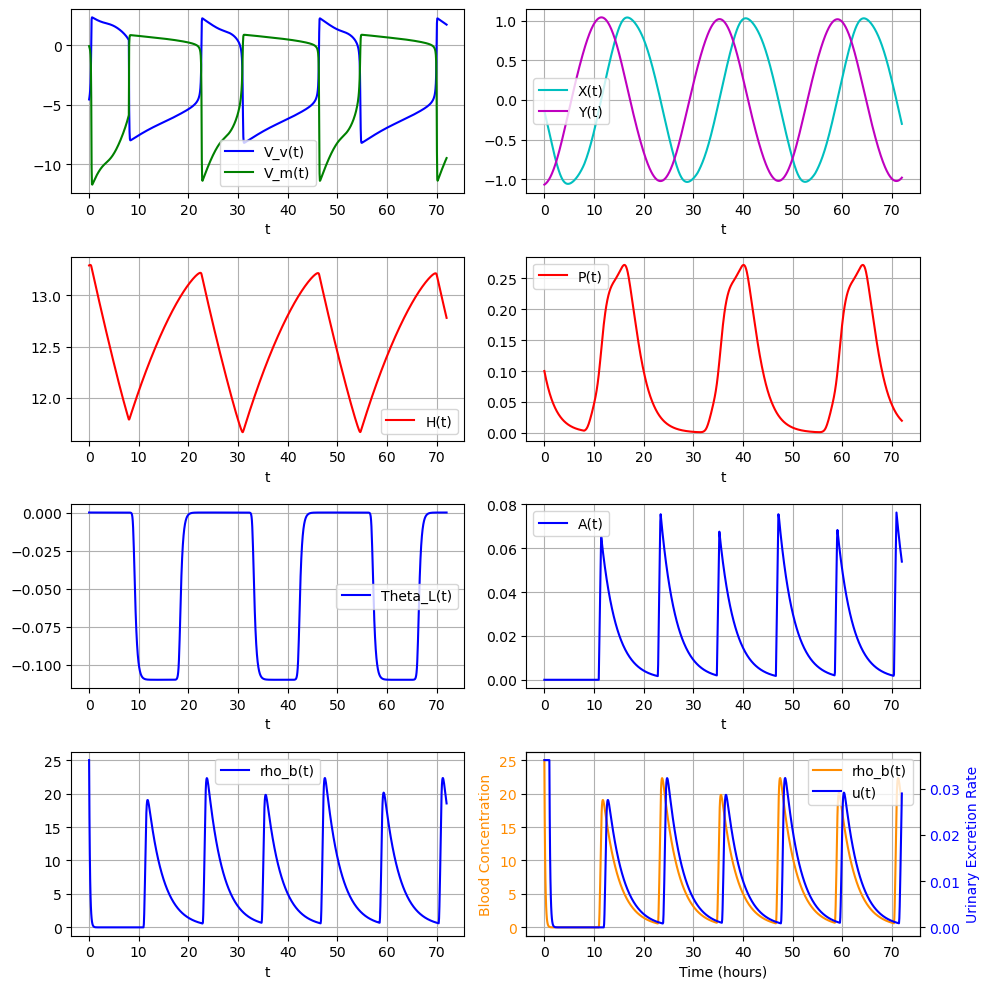

In [11]:
V_v = temp['V_v']
V_m = temp['V_m']
H = temp['H']
X = temp['X']
Y = temp['Y']
P = temp['P']
Theta_L = temp['Theta_L']
A = temp['A']
rho_b = temp['RHO_B']
aMT6s = temp['aMT6s']
t_hours = temp['time']/3600

### Plot ODEs
plt.figure(figsize=(10, 10))

plt.subplot(4,2,1)
plt.plot(t_hours, V_v, 'b', label='V_v(t)')
plt.plot(t_hours, V_m, 'g', label='V_m(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,2)
plt.plot(t_hours, X, 'c', label='X(t)')
plt.plot(t_hours, Y, 'm', label='Y(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,3)
plt.plot(t_hours, H, 'r', label='H(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,4)
plt.plot(t_hours, P, 'r', label='P(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,5)
plt.plot(t_hours, Theta_L, 'b', label='Theta_L(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,6)
plt.plot(t_hours, A, 'b', label='A(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,7)
plt.plot(t_hours, rho_b, 'b', label='rho_b(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(4,2,8)
# Primary axis for rho_b
ax1 = plt.gca()
ax1.plot(t_hours, rho_b, label='rho_b(t)', color='darkorange')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Blood Concentration', color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange')
ax1.grid(True)

# Secondary axis for aMT6s
ax2 = ax1.twinx()
ax2.plot(t_hours, aMT6s, label='u(t)', color='blue')
ax2.set_ylabel('Urinary Excretion Rate', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Create combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

In [12]:

for scenario_name, data in tqdm(rectangular_pulse_scenarios.items()):
    KSS = data['KSS']
    AMT6 = data['aMT6s']
    RHO_B = data['RHO_B']
    
    # Find the first scenario in each category that has the same KSS

    for name, metrics_data in rectangular_bursts_scenarios.items():
        if np.isclose(KSS, metrics_data['KSS'], atol=0.05).all():
            print(f"Found matching scenario: {name} for {scenario_name}")
            break

  0%|          | 0/3 [00:00<?, ?it/s]

Found matching scenario: 21531_rectangular_bursts_220lux_burst4140lux for 03192_rectangular_pulse_3202lux
Found matching scenario: 21531_rectangular_bursts_220lux_burst4140lux for 01413_rectangular_pulse_1423lux
Found matching scenario: 21531_rectangular_bursts_220lux_burst4140lux for 02007_rectangular_pulse_2017lux


In [ ]:
# Find one scenario in each category (constant, morning peak, afternoon peak, daylight) that has the same KSS, AMT6, and RHO_B (or close enough)
# Pick the first scenario in category constant, then loop over the other categories and find the first scenario that has the same KSS, AMT6, and RHO_B

# filter metrics' scenario name that include the word constant
# constant_scenarios = {k: v for k, v in metrics.items() if 'constant' in k}
# morning_peak_scenarios = {k: v for k, v in metrics.items() if 'morning_peak' in k}
# afternoon_peak_scenarios = {k: v for k, v in metrics.items() if 'afternoon_peak' in k}
# daylight_scenarios = {k: v for k, v in metrics.items() if 'daylight' in k}

# len(constant_scenarios), len(morning_peak_scenarios), len(afternoon_peak_scenarios), len(daylight_scenarios)

# first_key = next(iter(constant_scenarios))
# first_value = constant_scenarios[first_key]
# print(f"First scenario: {first_key}")
# print(f"KSS : {first_value['KSS']}")
# print(f"AMT6: {first_value['AMT6']}")
# print(f"RHO_B: {first_value['RHO_B']}")

In [ ]:

# for scenario_name, data in tqdm(constant_scenarios.items()):
#     KSS = data['KSS']
#     AMT6 = data['aMT6s']
#     RHO_B = data['RHO_B']
    
#     # Find the first scenario in each category that has the same KSS, AMT6, and RHO_B
#     for category, scenarios in [('morning_peak', morning_peak_scenarios), 
#                                 ('afternoon_peak', afternoon_peak_scenarios), 
#                                 ('daylight', daylight_scenarios)]:
#         for name, metrics_data in scenarios.items():
#             if np.isclose(KSS, metrics_data['KSS'], atol=0.005).all():
#                 print(f"Found matching scenario: {name} in category {category} for {scenario_name}")
#                 break

In [ ]:
# Define the scenario names for easier reference
labels = {
    'constant': '00092_constant_930lux',
    'morning_peak': '01704_morning_peak_830lux_peak7p0x',
    'afternoon_peak': '06879_afternoon_peak_880lux_peak2p0x',
    'daylight': '10692_daylight_1930lux'
} # tol = 0.01

labels = {
    'constant': '00267_constant_2680lux',
    'morning_peak': '04336_morning_peak_2380lux_peak5p5x',
    'afternoon_peak': '09620_afternoon_peak_2490lux_peak4p0x',
    'daylight': '11193_daylight_6940lux'
} # tol = 0.005

labels = {
    'rectangular_pulse': '00578_rectangular_pulse_588lux',
    'rectangular_bursts': '19295_rectangular_bursts_200lux_burst800lux'
}

# Get the common time vector
t = metrics['00578_rectangular_pulse_588lux']['time']
t_hours = t / 3600  # Convert seconds to hours

# Create a figure with three subplots
plt.figure(figsize=(15, 12))

# Plot 1: KSS for all scenarios
plt.subplot(4, 1, 1)
for label, scenario in labels.items():
    plt.plot(t_hours, metrics[scenario]['KSS'], label=scenario)
plt.title('Karolinska Sleepiness Scale (KSS)')
plt.ylabel('KSS Value')
plt.legend()
plt.grid(True)
plt.xlim(48, 72)
plt.xticks(range(48, 72, 1), range(0, 24, 1))

# Plot 2: AMT6 for all scenarios
plt.subplot(4, 1, 2)
for label, scenario in labels.items():
    plt.plot(t_hours, metrics[scenario]['aMT6s'], label=scenario)
plt.title('Urinary 6-sulphatoxymelatonin (aMT6s)')
plt.ylabel('aMT6saMT6s Value')
plt.legend()
plt.grid(True)
plt.xlim(48, 72)
plt.xticks(range(48, 72, 1), range(0, 24, 1))

# Plot 3: RHO_B for all scenarios
plt.subplot(4, 1, 3)
for label, scenario in labels.items():
    plt.plot(t_hours, metrics[scenario]['RHO_B'], label=scenario)
plt.title('Melatonin in Blood Plasma (RHO_B)')
plt.xlabel('Time (hours)')
plt.ylabel('RHO_B Value')
plt.legend()
plt.grid(True)
plt.xlim(48, 72)
plt.xticks(range(48, 72, 1), range(0, 24, 1))

# Plot 4: Irradiance for all scenarios
plt.subplot(4, 1, 4)  # Added new subplot for irradiance
for label, scenario in labels.items():
    plt.plot(t_hours, metrics[scenario]['irradiance'], label=scenario)
plt.title('Melanopic Equivalent Daylight Illuminance (Irradiance)')
plt.xlabel('Time (hours)')
plt.ylabel('Irradiance (lux)')
plt.legend()
plt.grid(True)
plt.xlim(48, 72)
plt.xticks(range(48, 72, 1), range(0, 24, 1))

plt.tight_layout()
plt.show()

KeyError: '00578_rectangular_pulse_588lux'